In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# cnn model vary kernel size
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot

from tensorflow.keras.utils import to_categorical
import tensorflow.keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Flatten, Reshape, GRU, Conv1D, MaxPooling1D, Bidirectional, ConvLSTM1D
from tensorflow.keras.layers import Input, TimeDistributed, Conv1D, MaxPooling1D, BatchNormalization, GlobalAveragePooling1D, Activation
from tensorflow.python.keras.utils import np_utils
from sklearn.metrics import precision_score, recall_score, f1_score

from typing import Any, Dict, List, Tuple
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns


def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values



# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y


# load the dataset, returns train and test X and y elements
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + '/content/drive/MyDrive/UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + '/content/drive/MyDrive/UCI HAR Dataset/')

    #zero-offset class values
    trainy = trainy - 1
    testy = testy - 1

    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot



In [4]:
trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)


In [5]:
print("X train shape: ", trainX.shape)
print("Y train shape: ", trainy.shape)
print("Y train One hot shape: ", trainy_one_hot.shape)
print("X test shape: ", testX.shape)
print("Y test shape: ", testy.shape)
print("Y test One hot shape: ", testy_one_hot.shape)

X train shape:  (7352, 128, 9)
Y train shape:  (7352, 1)
Y train One hot shape:  (7352, 6)
X test shape:  (2947, 128, 9)
Y test shape:  (2947, 1)
Y test One hot shape:  (2947, 6)


In [6]:
print("0: Walking:" ,np.where(trainy == 0)[0].size)
print("1: WU:" ,np.where(trainy == 1)[0].size)
print("2: WD:" ,np.where(trainy == 2)[0].size)
print("3: Sitting:" ,np.where(trainy == 3)[0].size)
print("4: Standing:" ,np.where(trainy == 4)[0].size)
print("5: Laying:" ,np.where(trainy == 5)[0].size)

0: Walking: 1226
1: WU: 1073
2: WD: 986
3: Sitting: 1286
4: Standing: 1374
5: Laying: 1407


In [7]:
unique, counts = np.unique(trainy, return_counts=True)
print ("Train data label statistics::")
print (np.asarray((unique, counts)).T)

unique, counts = np.unique(testy, return_counts=True)
print ("Test data label statistics::")
print (np.asarray((unique, counts)).T)

Train data label statistics::
[[   0 1226]
 [   1 1073]
 [   2  986]
 [   3 1286]
 [   4 1374]
 [   5 1407]]
Test data label statistics::
[[  0 496]
 [  1 471]
 [  2 420]
 [  3 491]
 [  4 532]
 [  5 537]]


In [8]:
X_train_all = trainX   # at this stage, the data includes both dynamic and static HAR data
y_train_all = trainy

X_test_all = testX
y_test_all = testy

In [9]:

trainy_one_hot = to_categorical(trainy)
testy_one_hot = to_categorical(testy)

In [10]:
print("X train shape: ", trainX.shape)
print("Y train shape: ", trainy.shape)
print("Y train One hot shape: ", trainy_one_hot.shape)
print("X test shape: ", testX.shape)
print("Y test shape: ", testy.shape)
print("Y test One hot shape: ", testy_one_hot.shape)

X train shape:  (7352, 128, 9)
Y train shape:  (7352, 1)
Y train One hot shape:  (7352, 6)
X test shape:  (2947, 128, 9)
Y test shape:  (2947, 1)
Y test One hot shape:  (2947, 6)


In [11]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train_one_hot,y_val_one_hot,y_train,y_val=train_test_split(trainX, trainy_one_hot, trainy,test_size=0.3,random_state=100)

In [12]:
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy_one_hot.shape[1]

# GRU1

In [15]:
# Model 1
model = Sequential()
model.add(GRU(128, input_shape=(n_timesteps, n_features)))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))

model.add(Dense(n_outputs, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 128)               53376     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dense_1 (Dense)             (None, 6)                 774       
                                                                 
Total params: 70662 (276.02 KB)
Trainable params: 70662 (276.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
58/58 [==============================] - 6s 20ms/step - loss: 1.3055 - accuracy: 0.4621 - val_loss: 1.0624 - val_accuracy: 0.5335
Epoch 2/10
58/58 [==============================] - 1s 10ms/step - loss: 0.9793 - accuracy: 0.5862 - val_loss: 0.8731 - val_accuracy: 0.6451
Epoch 3/10
58/58 [==============================] - 1s 13ms/step - loss: 0.7226 - accuracy: 0.6941 - val_loss: 0.5702 - val_accuracy: 0.7561
Epoch 4/10
58/58 [==============================] - 1s 19ms/step - loss: 0.5050 - accuracy: 0.8018 - val_loss: 0.4264 - val_accuracy: 0.8382
Epoch 5/10
58/58 [==============================] - 1s 15ms/step - loss: 0.3408 - accuracy: 0.8724 - val_loss: 0.2382 - val_accuracy: 0.9098
Epoch 6/10
58/58 [==============================] - 1s 18ms/step - loss: 0.2303 - accuracy: 0.9189 - val_loss: 0.1825 - val_accuracy: 0.9320
Epoch 7/10
58/58 [==============================] - 1s 24ms/step - loss: 0.1939 - accuracy: 0.9270 - val_loss: 0.1668 - val_accuracy: 0.9288
Epoch 8/10
58

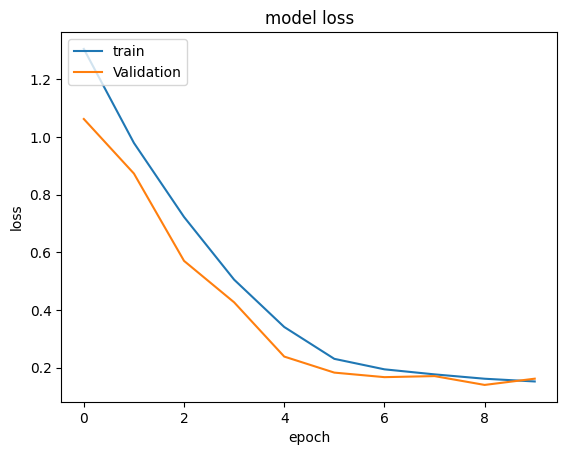

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

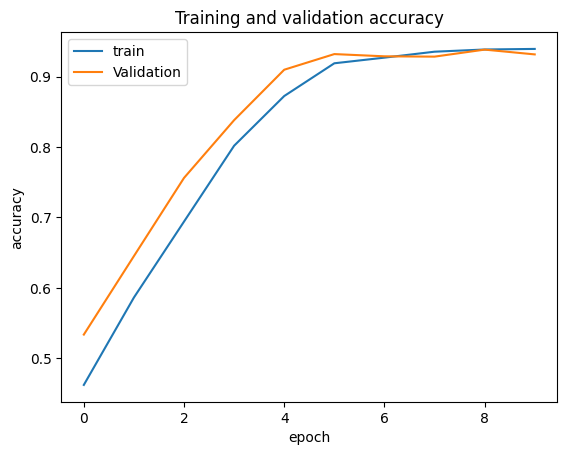

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

93/93 [==============================] - 1s 7ms/step
[[433  46  17   0   0   0]
 [  7 436  28   0   0   0]
 [  0  22 398   0   0   0]
 [ 13  10   2 350 116   0]
 [ 24   0   0  41 467   0]
 [  0  27   0   0   0 510]]
0.8802171700033933
0.8796295093309985
              precision    recall  f1-score   support

           0       0.91      0.87      0.89       496
           1       0.81      0.93      0.86       471
           2       0.89      0.95      0.92       420
           3       0.90      0.71      0.79       491
           4       0.80      0.88      0.84       532
           5       1.00      0.95      0.97       537

    accuracy                           0.88      2947
   macro avg       0.88      0.88      0.88      2947
weighted avg       0.89      0.88      0.88      2947



<Axes: >

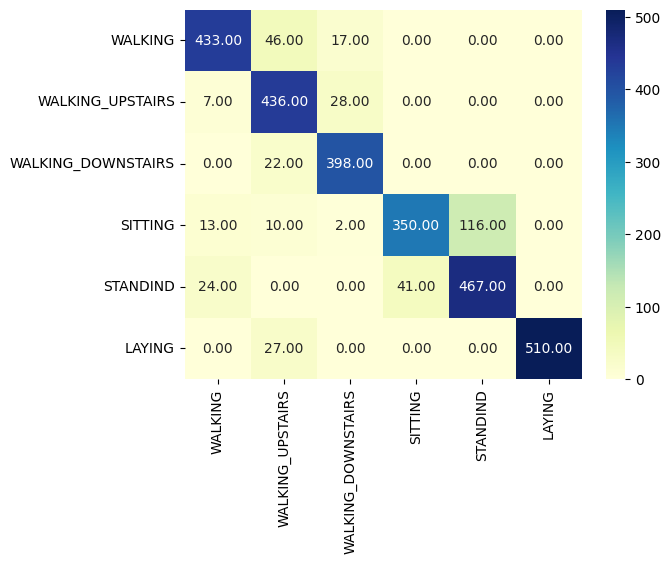

In [19]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# GRU 2


In [21]:
# Model 1
model = Sequential()
model.add(GRU(128, return_sequences=True, input_shape=(n_timesteps, n_features)))
model.add(Dropout(0.5))

model.add(GRU(128))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))

model.add(Dense(n_outputs, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 128, 128)          53376     
                                                                 
 dropout_1 (Dropout)         (None, 128, 128)          0         
                                                                 
 gru_2 (GRU)                 (None, 128)               99072     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                                 
Total params: 169734 (663.02 KB)
Trainable params: 169

In [22]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
58/58 [==============================] - 6s 36ms/step - loss: 1.2356 - accuracy: 0.4644 - val_loss: 1.0711 - val_accuracy: 0.5394
Epoch 2/10
58/58 [==============================] - 1s 21ms/step - loss: 0.8916 - accuracy: 0.6193 - val_loss: 0.6643 - val_accuracy: 0.7158
Epoch 3/10
58/58 [==============================] - 1s 21ms/step - loss: 0.5387 - accuracy: 0.7776 - val_loss: 0.5079 - val_accuracy: 0.7865
Epoch 4/10
58/58 [==============================] - 1s 20ms/step - loss: 0.3746 - accuracy: 0.8541 - val_loss: 0.2741 - val_accuracy: 0.8944
Epoch 5/10
58/58 [==============================] - 1s 20ms/step - loss: 0.2579 - accuracy: 0.9008 - val_loss: 0.2059 - val_accuracy: 0.9234
Epoch 6/10
58/58 [==============================] - 1s 20ms/step - loss: 0.1863 - accuracy: 0.9275 - val_loss: 0.1534 - val_accuracy: 0.9510
Epoch 7/10
58/58 [==============================] - 1s 22ms/step - loss: 0.1581 - accuracy: 0.9406 - val_loss: 0.1329 - val_accuracy: 0.9497
Epoch 8/10
58

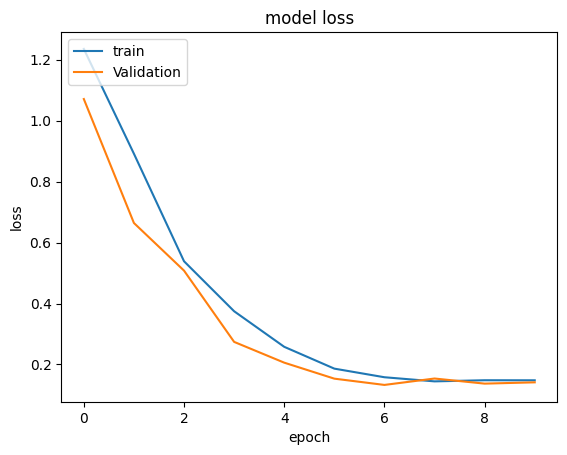

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

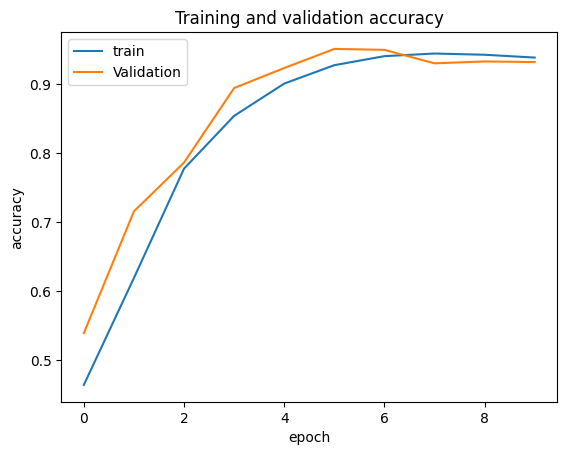

In [24]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

93/93 [==============================] - 1s 7ms/step
[[469   0  27   0   0   0]
 [ 33 415  23   0   0   0]
 [  0   0 420   0   0   0]
 [ 19   3   3 320 145   1]
 [ 21   0   0  32 479   0]
 [  0  27   0   0   0 510]]
0.8866644044791313
0.8844124759945261
              precision    recall  f1-score   support

           0       0.87      0.95      0.90       496
           1       0.93      0.88      0.91       471
           2       0.89      1.00      0.94       420
           3       0.91      0.65      0.76       491
           4       0.77      0.90      0.83       532
           5       1.00      0.95      0.97       537

    accuracy                           0.89      2947
   macro avg       0.89      0.89      0.89      2947
weighted avg       0.89      0.89      0.88      2947



<Axes: >

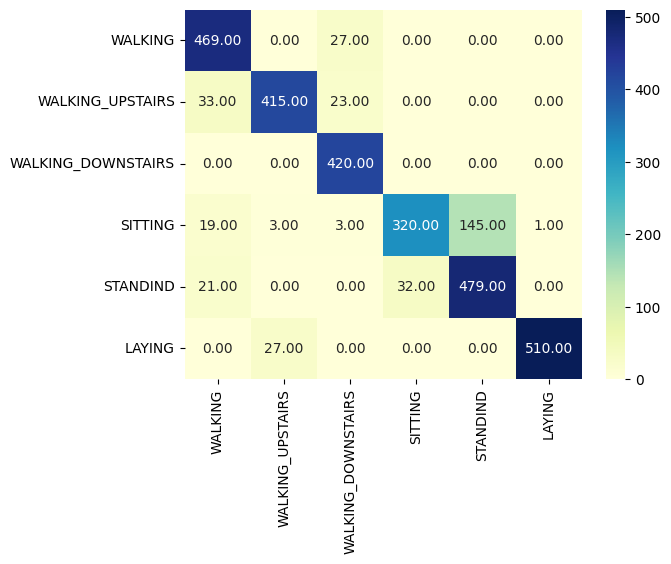

In [25]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# GRU 3

In [26]:
# Model 1
model = Sequential()
model.add(GRU(128, return_sequences=True, input_shape=(n_timesteps, n_features)))
model.add(Dropout(0.5))

model.add(GRU(128, return_sequences=True))
model.add(Dropout(0.5))

model.add(GRU(128))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))

model.add(Dense(n_outputs, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_3 (GRU)                 (None, 128, 128)          53376     
                                                                 
 dropout_3 (Dropout)         (None, 128, 128)          0         
                                                                 
 gru_4 (GRU)                 (None, 128, 128)          99072     
                                                                 
 dropout_4 (Dropout)         (None, 128, 128)          0         
                                                                 
 gru_5 (GRU)                 (None, 128)               99072     
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 128)              

In [27]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
58/58 [==============================] - 7s 45ms/step - loss: 1.2532 - accuracy: 0.4557 - val_loss: 1.0250 - val_accuracy: 0.5521
Epoch 2/10
58/58 [==============================] - 2s 27ms/step - loss: 0.8999 - accuracy: 0.6068 - val_loss: 0.6981 - val_accuracy: 0.6673
Epoch 3/10
58/58 [==============================] - 2s 30ms/step - loss: 0.5883 - accuracy: 0.7308 - val_loss: 0.4264 - val_accuracy: 0.7847
Epoch 4/10
58/58 [==============================] - 2s 31ms/step - loss: 0.4054 - accuracy: 0.7998 - val_loss: 0.3096 - val_accuracy: 0.8617
Epoch 5/10
58/58 [==============================] - 2s 29ms/step - loss: 0.2702 - accuracy: 0.8887 - val_loss: 0.2021 - val_accuracy: 0.9257
Epoch 6/10
58/58 [==============================] - 2s 30ms/step - loss: 0.1765 - accuracy: 0.9331 - val_loss: 0.1590 - val_accuracy: 0.9316
Epoch 7/10
58/58 [==============================] - 2s 31ms/step - loss: 0.1497 - accuracy: 0.9421 - val_loss: 0.1420 - val_accuracy: 0.9343
Epoch 8/10
58

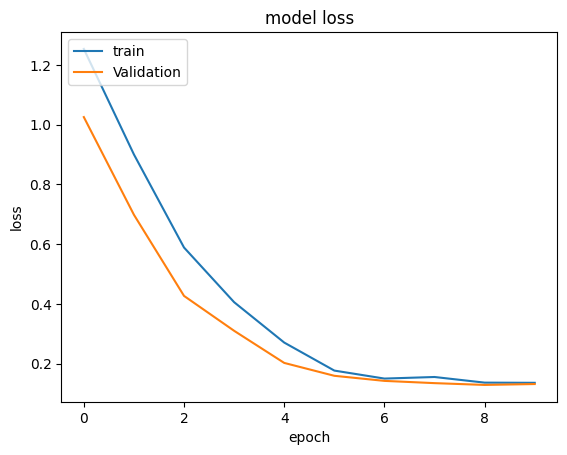

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

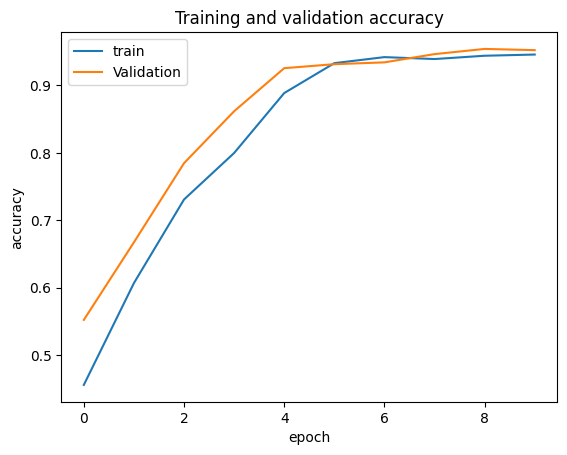

In [29]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

93/93 [==============================] - 1s 7ms/step
[[437   7  52   0   0   0]
 [ 25 418  28   0   0   0]
 [  0   0 420   0   0   0]
 [ 22   3   0 421  45   0]
 [  6   1   0 132 393   0]
 [  0  27   0   1   0 509]]
0.8815744825246012
0.8813132534672511
              precision    recall  f1-score   support

           0       0.89      0.88      0.89       496
           1       0.92      0.89      0.90       471
           2       0.84      1.00      0.91       420
           3       0.76      0.86      0.81       491
           4       0.90      0.74      0.81       532
           5       1.00      0.95      0.97       537

    accuracy                           0.88      2947
   macro avg       0.88      0.89      0.88      2947
weighted avg       0.89      0.88      0.88      2947



<Axes: >

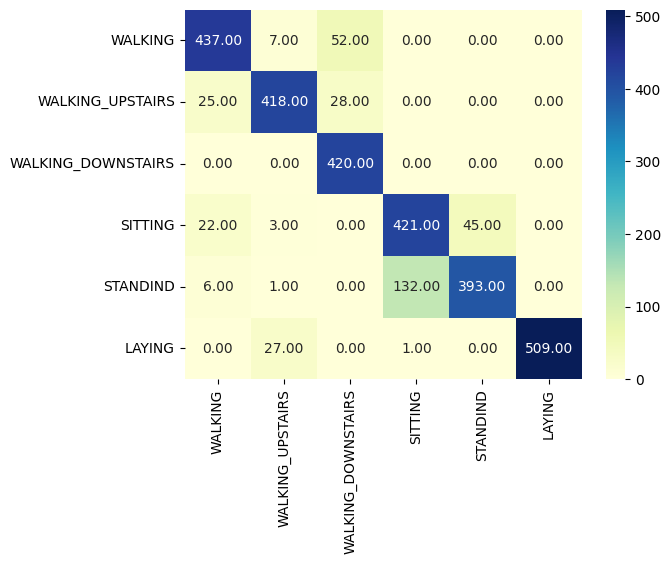

In [30]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# GRU 4

In [31]:
# Model 1
model = Sequential()
model.add(GRU(128, return_sequences=True , input_shape=(n_timesteps, n_features)))
model.add(Dropout(0.5))

model.add(GRU(128, return_sequences=True ))
model.add(Dropout(0.5))

model.add(GRU(128, return_sequences=True))
model.add(Dropout(0.5))
model.add(GRU(128))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))

model.add(Dense(n_outputs, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_6 (GRU)                 (None, 128, 128)          53376     
                                                                 
 dropout_6 (Dropout)         (None, 128, 128)          0         
                                                                 
 gru_7 (GRU)                 (None, 128, 128)          99072     
                                                                 
 dropout_7 (Dropout)         (None, 128, 128)          0         
                                                                 
 gru_8 (GRU)                 (None, 128, 128)          99072     
                                                                 
 dropout_8 (Dropout)         (None, 128, 128)          0         
                                                                 
 gru_9 (GRU)                 (None, 128)              

In [32]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
58/58 [==============================] - 10s 59ms/step - loss: 1.1726 - accuracy: 0.4921 - val_loss: 1.0367 - val_accuracy: 0.5798
Epoch 2/10
58/58 [==============================] - 2s 37ms/step - loss: 0.8690 - accuracy: 0.6202 - val_loss: 0.6476 - val_accuracy: 0.7158
Epoch 3/10
58/58 [==============================] - 3s 59ms/step - loss: 0.4931 - accuracy: 0.7881 - val_loss: 0.3918 - val_accuracy: 0.8359
Epoch 4/10
58/58 [==============================] - 3s 43ms/step - loss: 0.3477 - accuracy: 0.8617 - val_loss: 0.2359 - val_accuracy: 0.9252
Epoch 5/10
58/58 [==============================] - 2s 37ms/step - loss: 0.2115 - accuracy: 0.9240 - val_loss: 0.1388 - val_accuracy: 0.9397
Epoch 6/10
58/58 [==============================] - 2s 38ms/step - loss: 0.1842 - accuracy: 0.9309 - val_loss: 0.1400 - val_accuracy: 0.9433
Epoch 7/10
58/58 [==============================] - 2s 36ms/step - loss: 0.1451 - accuracy: 0.9442 - val_loss: 0.1460 - val_accuracy: 0.9365
Epoch 8/10
5

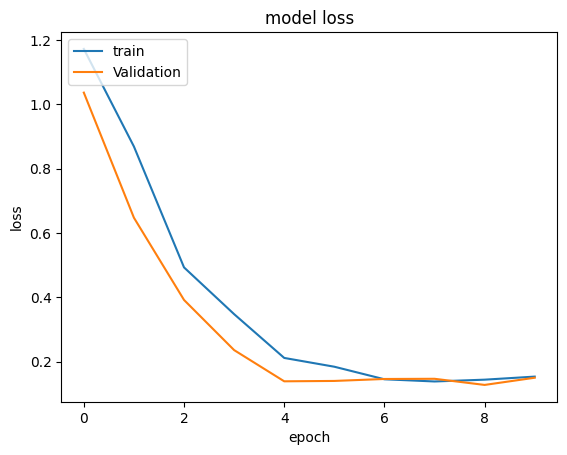

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

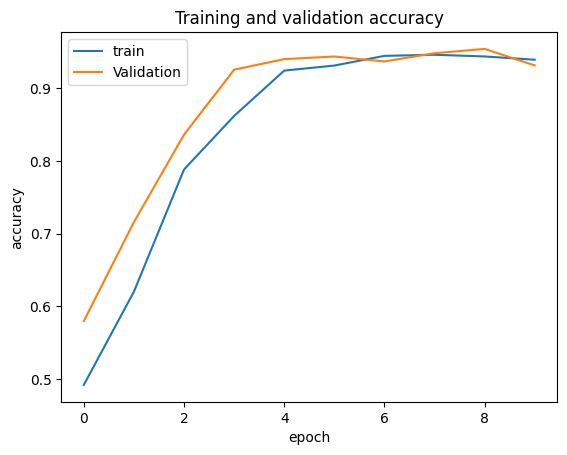

In [34]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

93/93 [==============================] - 2s 9ms/step
[[453   1  42   0   0   0]
 [  7 444  20   0   0   0]
 [  5   2 413   0   0   0]
 [  2  22   0 293 172   2]
 [  3   2   0  21 506   0]
 [  0   0   0   0   0 537]]
0.8978622327790974
0.8941919151956841
              precision    recall  f1-score   support

           0       0.96      0.91      0.94       496
           1       0.94      0.94      0.94       471
           2       0.87      0.98      0.92       420
           3       0.93      0.60      0.73       491
           4       0.75      0.95      0.84       532
           5       1.00      1.00      1.00       537

    accuracy                           0.90      2947
   macro avg       0.91      0.90      0.89      2947
weighted avg       0.91      0.90      0.89      2947



<Axes: >

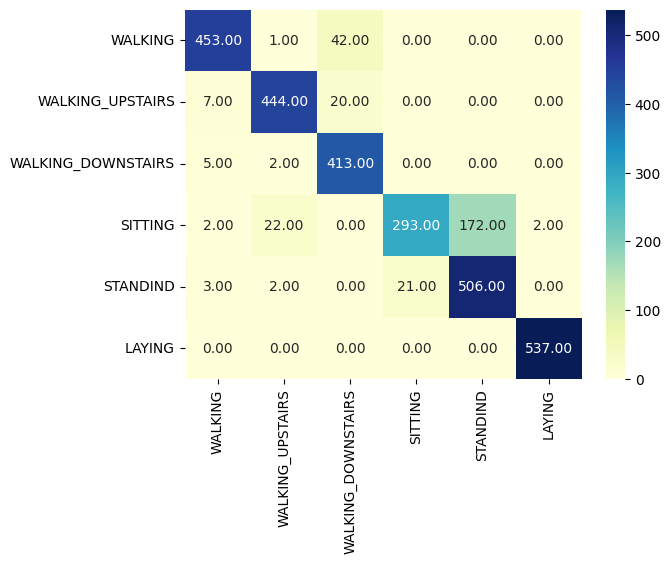

In [35]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# GRU5

In [36]:
# Model 1
model = Sequential()
model.add(GRU(128, return_sequences=True , input_shape=(n_timesteps, n_features)))
model.add(Dropout(0.5))

model.add(GRU(128, return_sequences=True ))
model.add(Dropout(0.5))

model.add(GRU(128, return_sequences=True))
model.add(Dropout(0.5))

model.add(GRU(128, return_sequences=True))
model.add(Dropout(0.5))

model.add(GRU(128))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))

model.add(Dense(n_outputs, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_10 (GRU)                (None, 128, 128)          53376     
                                                                 
 dropout_10 (Dropout)        (None, 128, 128)          0         
                                                                 
 gru_11 (GRU)                (None, 128, 128)          99072     
                                                                 
 dropout_11 (Dropout)        (None, 128, 128)          0         
                                                                 
 gru_12 (GRU)                (None, 128, 128)          99072     
                                                                 
 dropout_12 (Dropout)        (None, 128, 128)          0         
                                                                 
 gru_13 (GRU)                (None, 128, 128)         

In [37]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
58/58 [==============================] - 14s 73ms/step - loss: 1.2201 - accuracy: 0.4614 - val_loss: 1.0163 - val_accuracy: 0.5458
Epoch 2/10
58/58 [==============================] - 3s 45ms/step - loss: 0.9175 - accuracy: 0.5974 - val_loss: 0.6756 - val_accuracy: 0.7085
Epoch 3/10
58/58 [==============================] - 3s 46ms/step - loss: 0.5530 - accuracy: 0.7575 - val_loss: 0.3937 - val_accuracy: 0.8332
Epoch 4/10
58/58 [==============================] - 3s 47ms/step - loss: 0.3583 - accuracy: 0.8577 - val_loss: 0.2963 - val_accuracy: 0.8849
Epoch 5/10
58/58 [==============================] - 3s 47ms/step - loss: 0.2156 - accuracy: 0.9181 - val_loss: 0.1829 - val_accuracy: 0.9211
Epoch 6/10
58/58 [==============================] - 3s 45ms/step - loss: 0.1664 - accuracy: 0.9363 - val_loss: 0.1585 - val_accuracy: 0.9370
Epoch 7/10
58/58 [==============================] - 3s 46ms/step - loss: 0.1625 - accuracy: 0.9355 - val_loss: 0.1417 - val_accuracy: 0.9361
Epoch 8/10
5

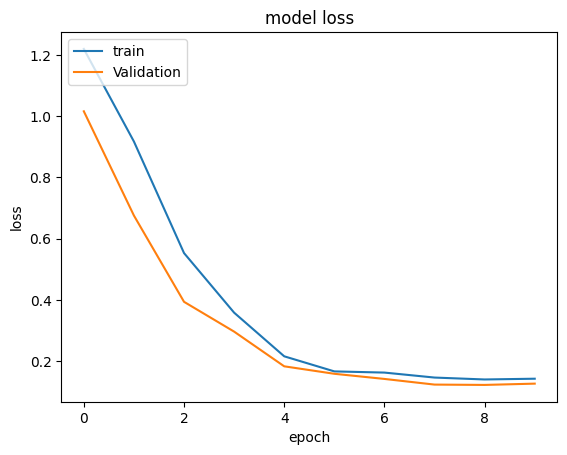

In [38]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

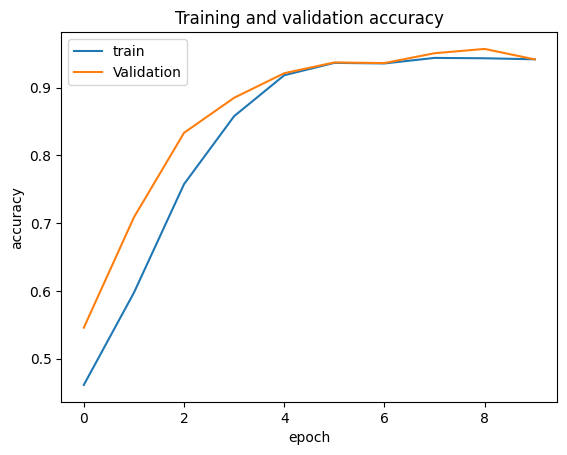

In [39]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

93/93 [==============================] - 3s 14ms/step
[[440   8  48   0   0   0]
 [  0 471   0   0   0   0]
 [  2  10 408   0   0   0]
 [  2  14   0 350 125   0]
 [  3   0   0  39 490   0]
 [  0   2   0   0   0 535]]
0.9141499830335935
0.9127237505050544
              precision    recall  f1-score   support

           0       0.98      0.89      0.93       496
           1       0.93      1.00      0.97       471
           2       0.89      0.97      0.93       420
           3       0.90      0.71      0.80       491
           4       0.80      0.92      0.85       532
           5       1.00      1.00      1.00       537

    accuracy                           0.91      2947
   macro avg       0.92      0.91      0.91      2947
weighted avg       0.92      0.91      0.91      2947



<Axes: >

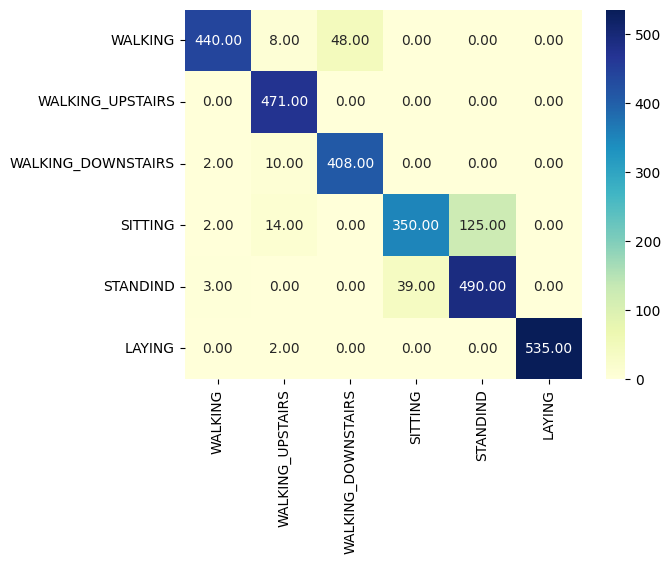

In [40]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')